# Introduction

This tutorial notebook aims to guide the user through the proposed 14-step impurity prediction workflow, shown below and implemented in Python using the RDKit cheminformatics package. The underlying reaction data used was downloaded from Reaxys® (Copyright © 2022 Elsevier Limited except certain content provided by third parties. Reaxys is a trademark of Elsevier Limited) using a proprietary API. **The data shown in this demonstration was used with Elsevier's permission.** More details on the workflow can be found in:

**(1) Arun, A., Guo, Z., Sung, S., & Lapkin, A. (2022). Reaction impurity prediction using a data mining approach. ChemRxiv. doi:10.26434/chemrxiv-2022-0btmt This content is a preprint and has not been peer-reviewed.**

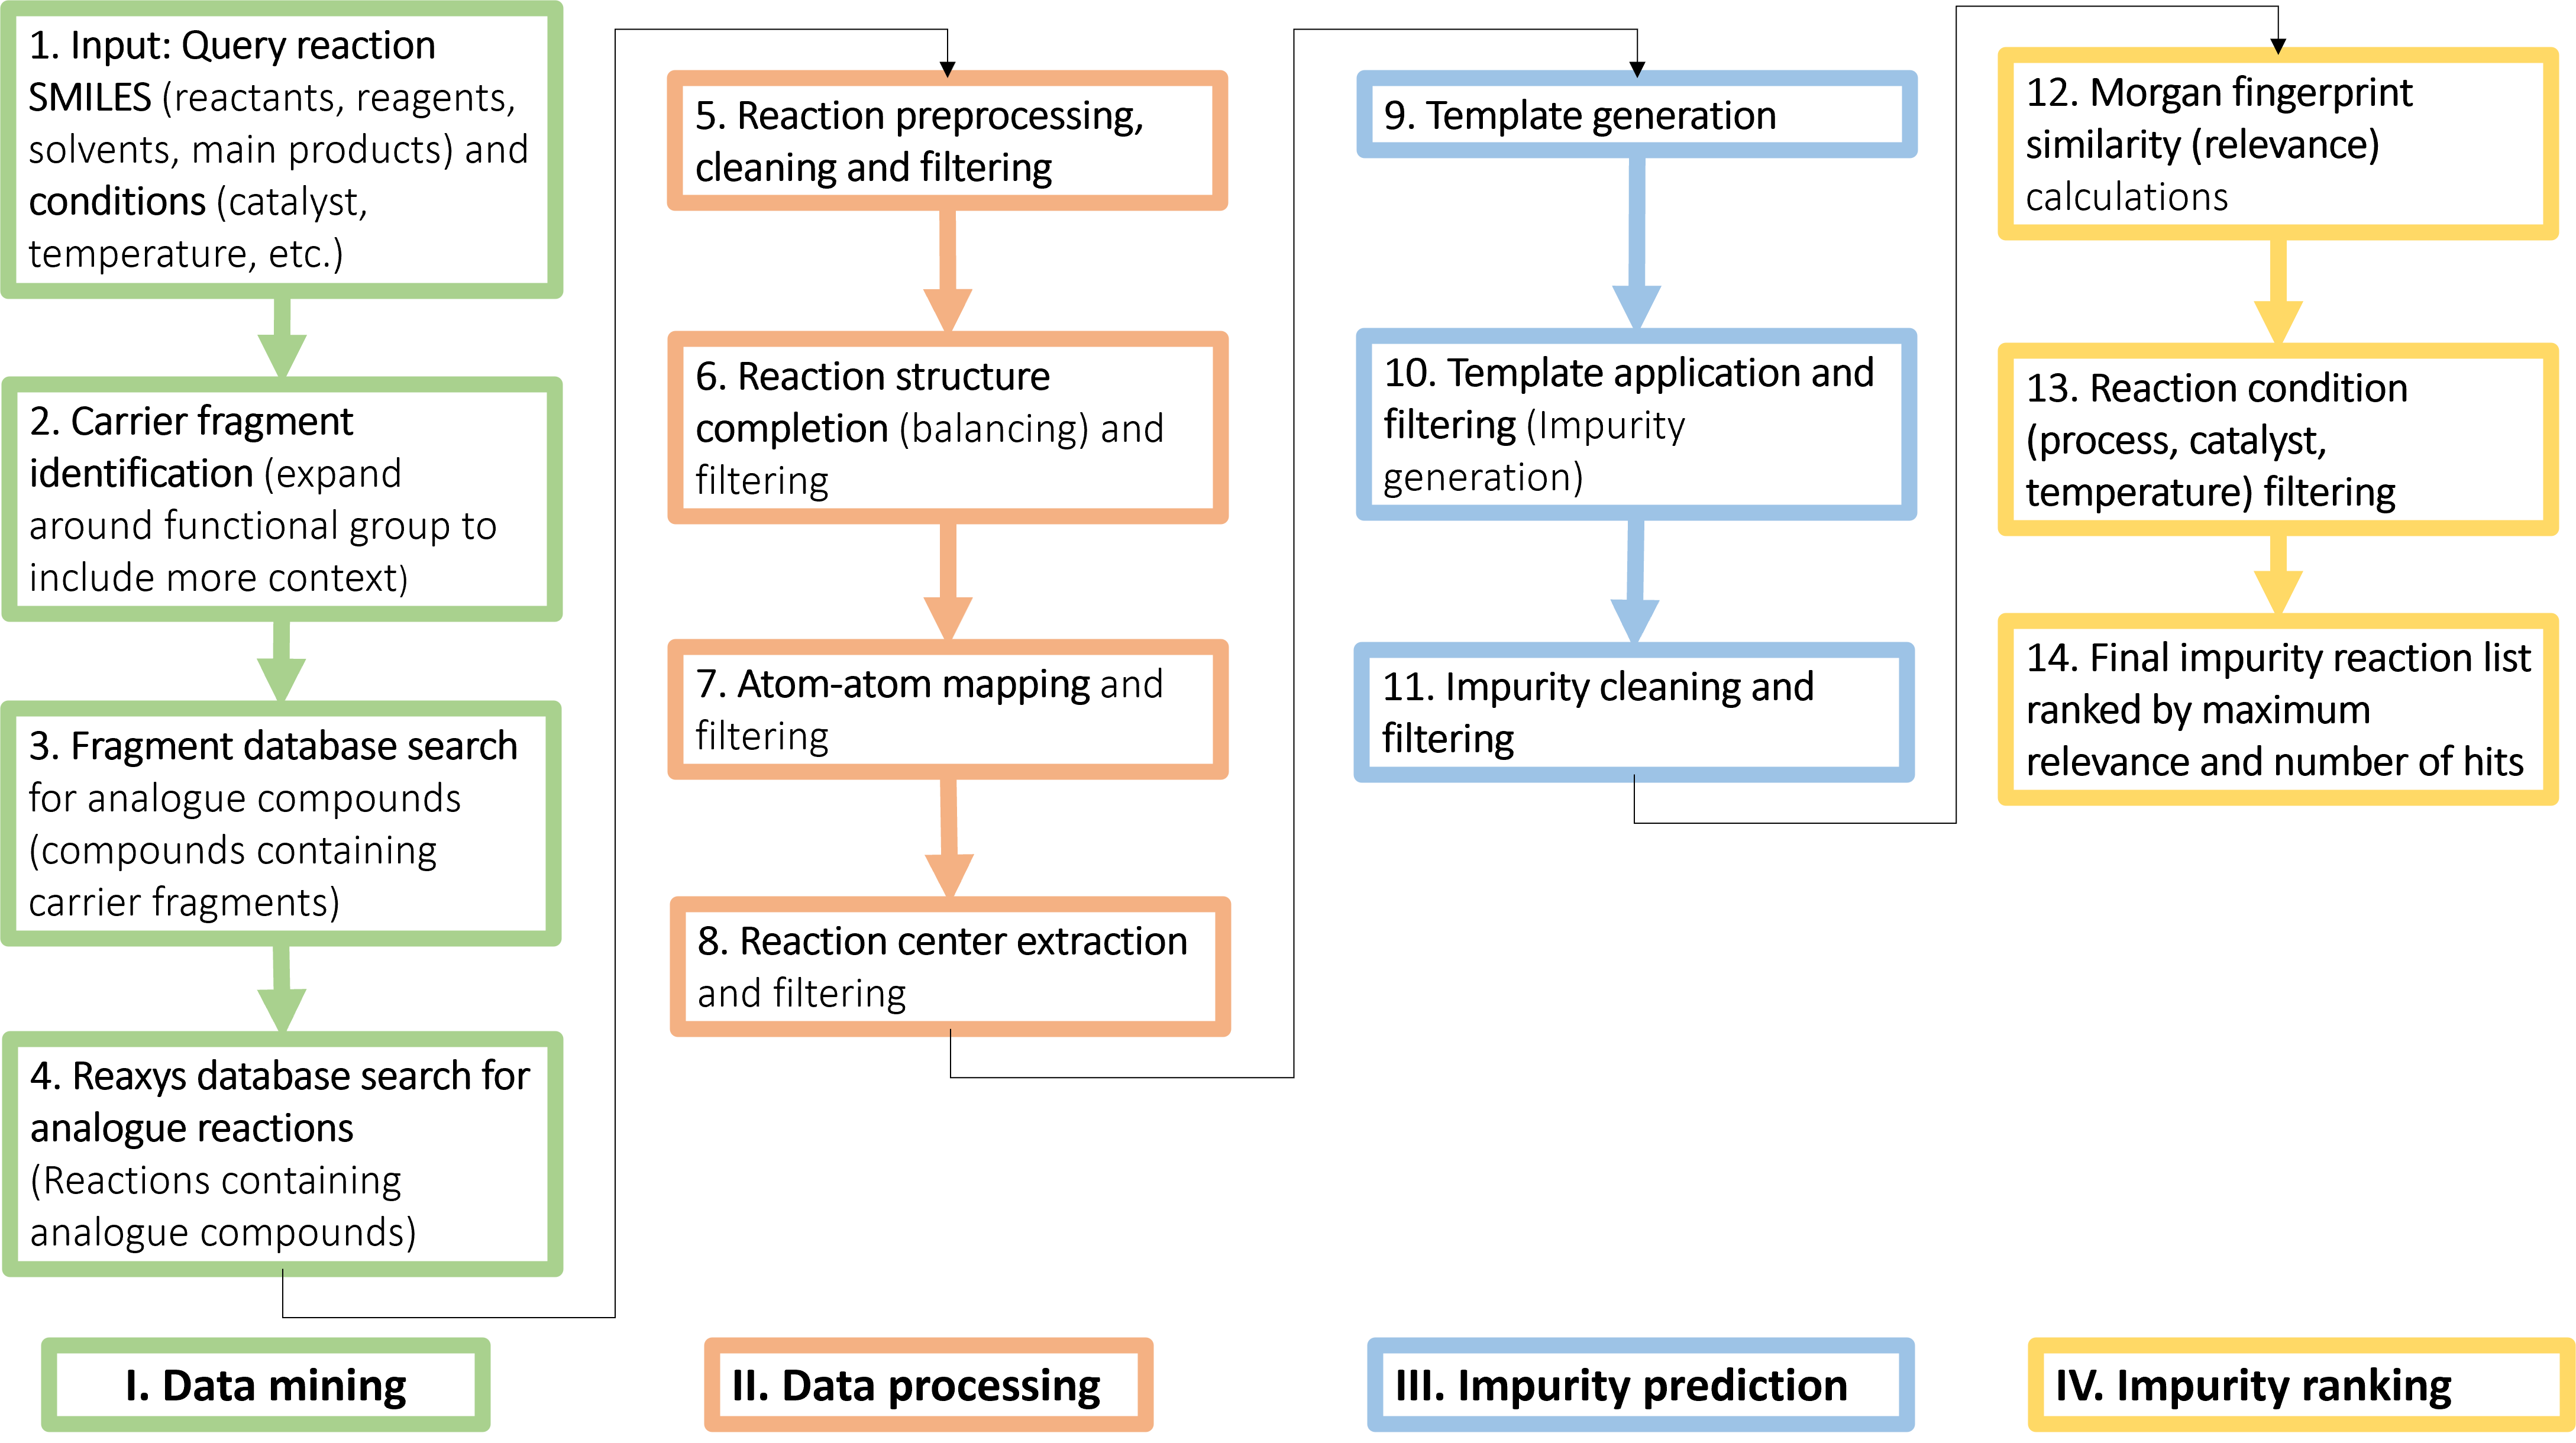

An example is shown in the following sections for a paracetamol case study. The relevant reaction scheme is shown below: (a) denotes the main reaction producting Paracetamol and (b) is the impurity reaction that should be predicted.

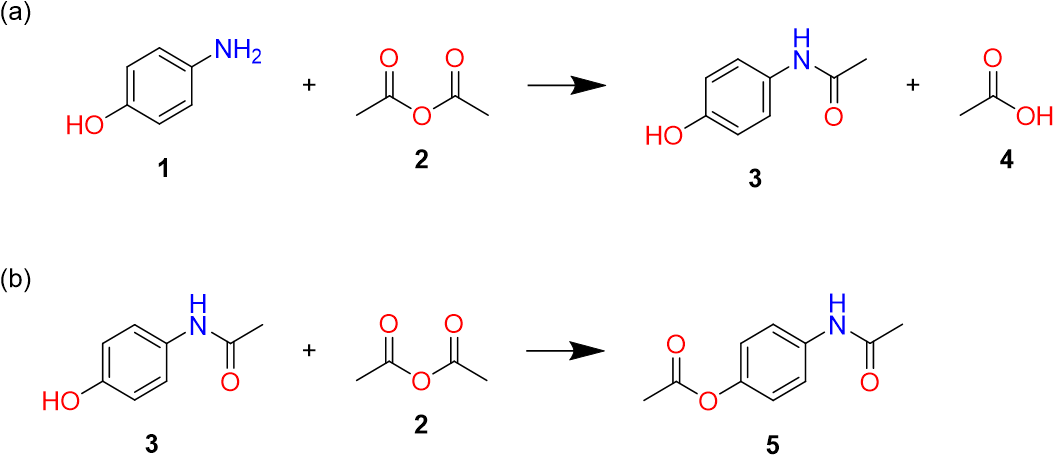

# Prerequisites

## Installation

The user is advised to follow installation instructions in the github repository as per `https://github.com/sustainable-processes/Impurity-Project`: 

Navigate to local project directory and:

`git clone https://github.com/sustainable-processes/Impurity-Project.git`

OR

`git clone git@github.com:sustainable-processes/Impurity-Project.git` if SSH is configured

To install dependencies, type the following in anaconda prompt or a compatible IDE:

`conda env create -f environment_win.yml -n <your-env-name>` if OS is windows, replace `your-env-name` with your choice

OR

`conda env create -f environment_linux.yml -n <your-env-name>` if OS is linux

Remember to activate the environment via `conda activate <your-env-name>`. Run the cell below, to make sure more than one output can be displayed at a time and basic functions are imported. For each section subsequently, read carefully and run the cells manually in order.


In [8]:
from IPython.core.interactiveshell import InteractiveShell #Allow more than one output
InteractiveShell.ast_node_interactivity = "all"
!conda info
from MainFunctions import openpickle
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdChemReactions


     active environment : impurityproject
    active env location : /home/aa2133/miniconda3/envs/impurityproject
            shell level : 2
       user config file : /home/aa2133/.condarc
 populated config files : 
          conda version : 4.11.0
    conda-build version : not installed
         python version : 3.8.3.final.0
       virtual packages : __linux=4.4.0=0
                          __glibc=2.23=0
                          __unix=0=0
                          __archspec=1=x86_64
       base environment : /home/aa2133/miniconda3  (writable)
      conda av data dir : /home/aa2133/miniconda3/etc/conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/linux-64
                          https://repo.anaconda.com/pkgs/r/noarch
          package cache : /home/aa2133/miniconda3/pkgs
                      

In [40]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 150em; }</style>"))

In [ ]:
%load_ext autoreload
%autoreload 2

## Data

The workflow requires prerequisite data in the form of a reaction dataframe, substance dataframe, and fragment dataframe (major requirements). There are also some minor requirements which require some transformation of the major dataframes which is also explained. The below sections give an overview of the data formats required. The user is recommended to store each of these major dataframes and minor data in a folder and store the folder file path as a variable. This is stored below under `masterdbreadpath`.

In [14]:
masterdbreadpath="/home/aa2133/Impurity-Project/Reaxys_Data/" # Change as required

### Reaction dataframe

A major source of data for this project is a reaction dataframe,`reactiondb`, stored in the `rxnsource` file path and consisting of approximately 17 million reactions downloaded from Reaxys. Considering the entirety of Reaxys as a reaction network (nodes as molecules and edges linking molecules involved in reaction), this set of reactions was taken from the core (substance 774355 with a search depth of 10 steps forward and 1 backward). A proprietary API was used to retrieve these reactions.

In [6]:
rxnsource=masterdbreadpath+'ReactionDB2.pickle'

In [7]:
reactiondb=pd.read_pickle(rxnsource)

`reactiondb` has 23 columns: 
* **Reaction ID** (Reaxys ID, can be other databases too) --INDEX
* **Instance** (Each reaction can have more than one set of unique conditions) --INDEX
* **NumRefs** (Number of references indicating the reaction)
* **ReactantID** (Reaxys ID for reactants, can be other databases too)
* **MissingReactant** (Reactants that are indicated in Reaxys as raw text but cannot be processed/don't have mol files or SMILES)
* **Product ID** (Reaxys ID for products, can be other databases too)
* **MissingProduct** (Products that are indicated in Reaxys as raw text but cannot be processed/don't have mol files or SMILES)
* **NumSteps** (Number of steps associated with the reaction ie. single or multi-step)
* **NumStages** (Number of stages associated with the reaction)
* **ReagentID** (Reaxys ID for reagents, can be other databases too)
* **MissingReagent** (Reagents that are indicated in Reaxys as raw text but cannot be processed/don't have mol files or SMILES)
* **Temperature** (Temperature of reaction instance, can be either single number or a range)
* **Pressure** (Pressure of reaction instance)
* **ReactionTime** (Time taken for reaction to occur)
* **SolventID** (Reaxys ID for solvents, can be other databases too)
* **MissingSolvent** (Solvents that are indicated in Reaxys as raw text but cannot be processed/don't have mol files or SMILES)
* **CatalystID** (Reaxys ID for catalysts, can be other databases too)
* **MissingCatalyst** (Catalysts that are indicated in Reaxys as raw text but cannot be processed/don't have mol files or SMILES)
* **ConditionNotes** (Additional notes on reaction conditions)
* **ReactionType** (Class of reactions)
* **NameDict** (Dictionary with keys as Reaxys IDs and values as species names)
* **YearPublished** (Year published)
* **Yield** (Dictionary with keys as Reaxys IDs and values as percentage yields

An example is shown below for reaction 8624923. Other data sources (besides Reaxys) can be used as long as the previous columns exist in the dataframe 

In [22]:
reactiondb.xs(8624923,drop_level=False)
reactiondb.xs(8624923,drop_level=False).dtypes

NumRefs         ReactantID MissingReactant ProductID  \
ReactionID Instance                                                         
8624923    0               6  [1427741, 385737]              []   [98170]   
           1               6  [1427741, 385737]              []   [98170]   
           2               6  [1427741, 385737]              []   [98170]   
           3               6  [1427741, 385737]              []   [98170]   
           4               6  [1427741, 385737]              []   [98170]   
           5               6  [1427741, 385737]              []   [98170]   

                    MissingProduct NumSteps  NumStages           ReagentID  \
ReactionID Instance                                                          
8624923    0                    []        1          1           [3587194]   
           1                    []        1          2  [2037554, 3587155]   
           2                    []        1          1           [2037554]   
           3                    []        1          2  [3587194, 1098229]   
           4                    []        1          1           [2037554]   
           5                    []        1          1           [2037554]   

                    MissingReagent      Temperature  ... ReactionTime  \
ReactionID Instance                                  ...                
8624923    0                    []         [0 - 25]  ...          [3]   
           1                    []             [60]  ...          [1]   
           2                    []             [20]  ...         [16]   
           3                    []     [0 - 25, 25]  ...      [3, 18]   
           4                    []             [60]  ...           []   
           5                    []  [49.85 - 59.85]  ...          [1]   

                    SolventID MissingSolvent CatalystID MissingCatalyst  \
ReactionID Instance                                                       
8624923    0               []             []         []              []   
           1               []             []         []              []   
           2         [741857]             []         []              []   
           3               []             []         []              []   
           4               []             []         []              []   
           5               []             []         []              []   

                    ConditionNotes   ReactionType  \
ReactionID Instance                                 
8624923    0                        [Acetylation]   
           1                                   []   
           2                                   []   
           3                                   []   
           4                                   []   
           5                                   []   

                                                              NameDict  \
ReactionID Instance                                                      
8624923    0         {1427741: 'D-glucuronic acid', 385737: 'acetic...   
           1         {1427741: 'D-glucuronic acid', 385737: 'acetic...   
           2         {1427741: 'D-glucuronic acid', 385737: 'acetic...   
           3         {1427741: 'D-glucuronic acid', 385737: 'acetic...   
           4         {1427741: 'D-glucuronic acid', 385737: 'acetic...   
           5         {1427741: 'D-glucuronic acid', 385737: 'acetic...   

                    YearPublished          Yield  
ReactionID Instance                               
8624923    0               [2000]  {98170: 82.0}  
           1               [2011]  {98170: 66.0}  
           2               [2001]  {98170: 62.0}  
           3               [2004]  {98170: 55.0}  
           4               [2003]  {98170: 50.0}  
           5               [2005]  {98170: 49.8}  

[6 rows x 21 columns]

NumRefs             Int64
ReactantID         object
MissingReactant    object
ProductID          object
MissingProduct     object
NumSteps           object
NumStages           Int64
ReagentID          object
MissingReagent     object
Temperature        object
Pressure           object
ReactionTime       object
SolventID          object
MissingSolvent     object
CatalystID         object
MissingCatalyst    object
ConditionNotes     string
ReactionType       object
NameDict           object
YearPublished      object
Yield              object
dtype: object

### Substance dataframe

**Major**

The substance dataframe, `substancedb`, is stored in the `substancesource` file path and contains data on all ~16 million species in the reaction dataframe, namely **SubstanceID** (Reaxys ID), **Smiles**, and **>1 Compound** which identifies whether the species is a mixture of any kind ('.' in SMILES eg. salt) or not. The proprietary API was used again to retrieve mol files which were then processed by RDKit and canonicalized into SMILES. Alternate substance dataframes could be used as long as it is in the correct format. 

In [9]:
substancesource=masterdbreadpath+'SubstanceSmiles.pickle'

In [5]:
substancedb=pd.read_pickle(substancesource)

In [50]:
substancedb[:10]
substancedb.dtypes

,Smiles,>1 Compound
SubstanceID,,
6890270,CC(C)(C)[C@@H]1CC[C@@](C)(F)[C@H](Br)C1,False
27615522,Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F,False
29164535,[Gd+3].[Na+].[O-]B([O-])[O-].[Tb+3],True
11230426,Nc1cc(F)c(N2CC(F)C2)c(F)c1,False
9019791,CCCCOc1ccc(-c2nc(-c3ccc(Cl)cc3)[nH]c2-c2ccncc2...,False
4584084,CC(C)(C)OC(=O)C=C1C[N+]([O-])=C(c2ccccc2F)c2cc...,False
918811,Cc1cc([N+](=O)[O-])cc([N+](=O)[O-])c1NN,False
11185773,Cc1ccccc1CCCCCCC(=O)c1ncc(-c2ccccn2)o1,False
6156831,CCOC(=O)c1c(-c2cccc([N+](=O)[O-])c2)cc(-c2cccc...,False


Smiles          string
>1 Compound    boolean
dtype: object

**Minor**

Processing Reaxys species could lead to errors (eg. valence errors, kelulization errors, missing mol files etc.). Therefore, a set of species with these errors was assembled as `unresolvedids` stored under the file path specified by `unresolvedsource`. Note that each ID is a Reaxys ID. This is optional, mostly for data quality purposes.

In [10]:
unresolvedsource=masterdbreadpath+'UnresolvedIDs.pickle'

In [11]:
unresolvedids=openpickle(unresolvedsource)

In [178]:
len(unresolvedids)
list(unresolvedids)[:20]

1403428

[16777216,
 1,
 16777223,
 8388629,
 16777240,
 20971545,
 16777244,
 16777247,
 29360173,
 8388667,
 16777286,
 29360211,
 29360212,
 29360213,
 29360214,
 29360215,
 29360216,
 16777304,
 8388693,
 8388699]

Another important factor to consider is reaction role assignment. For the data mining module in Section 3.1, analogue reactions are retrieved based on the criteria that both reactants and reagents are analogue (different solvents and catalysts are permitted to allow for sufficient results). However, a species can act as a reagent in a certain reaction but also as a catalyst in others, and sometimes it is not clear exactly what its role is in a reaction database. `exemptionlist`, stored under file path `exemptionsource` is a list of species that occur as a catalyst in more than 5 % of reactions they are involved in.  If a species is in `exemptionlist`, even if it is non-analogue as a reagent the reaction will still be considered in the off-chance that it behaves as a catalyst. This is optional.

In [12]:
exemptionsource=masterdbreadpath + "PotCatList.pickle"

In [13]:
exemptionlist=openpickle(exemptionsource)

In [183]:
exemptionlist[:10]

[1142, 1222, 1368, 1429, 1453, 2071, 2752, 2815, 3162, 3956]

### Fragment dataframe

**Major**

The final input is a fragment dataframe, `fragdb` which will be needed in Step 4 of the workflow. This is a dataframe containing all carrier fragments expanded from identified functional groups for each species in the substance dataframe. An example is shown below for generating this fragment dataframe with an expansion value of 1 (For each species, each identified functional group is expanded to the nearest neighboring atom (s)). Note that the operation has been parallelized across 16 CPU cores; the user is advised to change `ncpus` based on the system being used.

In [45]:
from FunctionsDB import createfragdb

In [46]:
fragdb=createfragdb(substancedb,ncpus=16,resFormat='smiles')

2022-08-17 10:07:33,454	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


`fragdb` has 5 columns:

* **FragmentSmiles** (SMILES of carrier fragment present in species)
* **SubstanceID** (Reaxys ID of species)
* **Smiles** (SMILES of species)
* **>1 Compound** (True if species is a mixture)
* **count** (Number of associated carrier fragments present in species)

In [7]:
fragdb[:10]

,,count,Smiles,>1 Compound
FragmentSmiles,SubstanceID,,,
CF,6890270,1,CC(C)(C)[C@@H]1CC[C@@](C)(F)[C@H](Br)C1,False
CBr,6890270,1,CC(C)(C)[C@@H]1CC[C@@](C)(F)[C@H](Br)C1,False
cnc,27615522,1,Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F,False
cF,27615522,2,Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F,False
[H]C1([H])OccO1,27615522,1,Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F,False
[Gd+3],29164535,1,[Gd+3].[Na+].[O-]B([O-])[O-].[Tb+3],True
[Na+],29164535,1,[Gd+3].[Na+].[O-]B([O-])[O-].[Tb+3],True
[O-]B([O-])[O-],29164535,1,[Gd+3].[Na+].[O-]B([O-])[O-].[Tb+3],True
[Tb+3],29164535,1,[Gd+3].[Na+].[O-]B([O-])[O-].[Tb+3],True


The above fragment dataframe can be written to a pickle file and read for future usage, shown below. For this tutorial it is stored in the `fragdbsource` file path.

In [6]:
fragdbsource=masterdbreadpath+'fragdb.pickle'

In [7]:
fragdb=pd.read_pickle(fragdbsource)

Visualization of fragments for a particular species can be easily performed using the `visfragment` function, as shown below. The widgets can be controlled to see which fragments are present in a species.

In [18]:
from Visualize import visfragment

In [45]:
visfragment(fragdbsource=fragdb[:12],displayres=True)

<h3><center><strong>Species</strong></center></h3>

<h3><center><strong>Fragments</strong></center></h3>

Output()

**Minor**

A fragment frequency dataframe, `fragfreq` is another required input. It contains 3 columns: `FragmentSmiles`; `Frequency`, the frequency of the fragment in `substancedb`; and `Popularity`, the percentage popularity of the fragment. Generation is easily performed by invoking the `genfragfreq` function on `fragmentdb`, and sorting based on the popularity column (percentage occurrence) as shown below. Only the top 10 fragments (SMILES) are shown.

In [169]:
from FunctionsDB import createfragfreq

In [170]:
fragfreq=createfragfreq(fragdb)
fragfreq.sort_values(by=['Popularity'],ascending=False)[:10]

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,FragmentSmiles,Frequency,Popularity
2,cnc,2820013,6.0
13,cOC,2743793,5.0
41,COC(C)=O,1765485,4.0
32,[H]OC,2176832,4.0
15,cCl,1362946,3.0
33,COC,1693827,3.0
37,CN(C)C,993693,2.0
75,[H]Oc,756164,2.0
89,c=O,915341,2.0
99,cn(c)C,933230,2.0


`fragfreq` can be written to a pickle file and stored, in this case, the file path under `fraggroupssource`.

# Workflow demo

A workflow demo is shown below for the paracetamol case study, going through all 14 steps. 3.1 covers data mining (steps 1-4), 3.2 covers data processing (steps 5 - 8) , 3.3 covers impurity prediction (steps 9 - 11) and 3.4 covers impurity ranking (steps 12 - 14) with the final visualization of the results. The workflow was run on a linux server (Ubuntu 16.04.6 LTS, x86_64, 32 CPUs (Intel(R) Xeon(R) CPU E5-2650 v2 @ 2.60GHz)).

The workflow takes in a configuration dictionary, `IP` which includes all the necessary prerequisite major and minor data requirements. Here, the dataframes are directly specified, and `showresults` is specified as True and `writetofile` is specified as False. Be advised that this will require anywhere between 80 and 90 gb of memory due to parallel processing across 16 cores. However, this is the simplest way to run the function as all outputs are directly stored in `IP`. If the user wishes to save memory, it is better to write each input dataframe to a pickle file, refresh the kernel, and specify file paths instead. Specify `showresults` as False, `writetofile` as True and add `folderwritepath` (directory to store results) to IP. The workflow routine automatically will read and write the necessary data. 

In [ ]:
IP={'substancedb':substancedb, #*MANDATORY* Substance dataframe, specify either a file path (substancesource) or a loaded dataframe (substancedb)
    'rxnsource': reactiondb,   # *MANDATORY* Reaction dataframe, specify either a file path (rxnsource) or a loaded dataframe (reactiondb)
    'fragdbsource':fragdb,     # *MANDATORY* Fragment dataframe, specify either a file path (fragdbsource) or a loaded dataframe (fragdb)
    'unresolvedsource':unresolvedids, #Unresolved Reaxys IDs, specify file path (unresolvedsource), list (unresolvedids) or None
    'exemptionsource':exemptionlist,  #List of species that could be catalysts, specify file path (exemptionsource), list (exemptionlist) or None
    'fraggroupssource':fragfreq,       # Fragment frequency dataframe, specify file path (fraggroupssource) or dataframe (fragfreq) or None
   'showresults':True,         # Whether results are directly returned or not, specif False to save memory
   'writetofile':False}        #Whether results are written to file, specify True to save memory
                               # If True, 'folderwritepath' required eg. 'folderwritepath': "/home/aa2133/Impurity-Project/Input/"

## Data mining (Steps 1 - 4)

The data mining module seeks to identify carrier fragments (based on functional groups) in each query species identified in a reaction passed in by a user, retrieve analogue species that contain these carrier fragments as well as all analogue reactions that contain these analogue species.

**Input**

As outlined in step 1, based on the paracetamol query reaction, the user input should be a reaction SMILES containing all possible reactants, reagents, solvents and catalysts on the left-hand-side and all possible products on the right-hand-side. This reaction is visualized by RDKit below.

Reaction SMILES: Nc1ccc(O)cc1.CC(=O)OC(C)=O>>CC(=O)Nc1ccc(O)cc1.CC(=O)O


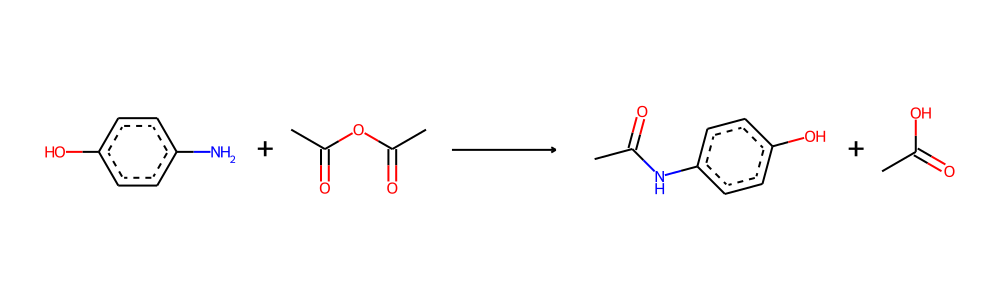

In [20]:
print("Reaction SMILES: Nc1ccc(O)cc1.CC(=O)OC(C)=O>>CC(=O)Nc1ccc(O)cc1.CC(=O)O")
from MainFunctions import drawReaction
drawReaction(rdChemReactions.ReactionFromSmarts("Nc1ccc(O)cc1.CC(=O)OC(C)=O>>CC(=O)Nc1ccc(O)cc1.CC(=O)O",useSmiles=True))

Subsequently, passing this input into the workflow is performed by invoking the `main` function. The function takes in a `casename` (to create directories to store outputs in); a list of `steps` to perform; `userinput` which is the reaction SMILES string above; any catalysts, `catalyst`; and temperature range, `Trange`. The latter two arguments are not relevant to this case study and therefore are not added. The last argument is an input parameter dictionary, `IP`, containing all relevant parameters for steps (a default is automatically initiated and it is up to the user to pass in any changes as additional arguments. 

An example is shown below for the data mining section of the workflow (steps 2 to 4) which retrieves analogue reactions containing analogue species that have any carrier fragments present in query species in the `userinput` reaction SMARTS string. Here results are not written to file to save time. A full list of available parameters to tweak can be seen in the `main` function body and docustring.

In [15]:
IP.update({'reaxys_updated':True, # Whether reactiondb already has been updated by Reaxys and has the correct 23-column format
   'reaxys_update':False,      # Whether existing reactions need to be updated by Reaxys (not available as API cannot be shared)
    'expand': 1,                # How many atoms to expand identified functional groups by, forming carrier fragments
   'ncpus': 16,                # Number of CPUs to perform function call on (change depending on the system)
    'workflow':'strict',       # Workflow to run, strict means reactions are considered analogue only if reactants and reagents are analogue
    'returnall':False})         # Whether all workflows are run and returned

In [5]:
from MainScript import main

In [17]:
IP=main('Case2',steps=[2,3,4],userinput="Nc1ccc(O)cc1.CC(=O)OC(C)=O>>CC(=O)Nc1ccc(O)cc1.CC(=O)O",**IP)

Step 2 complete


2022-08-24 09:39:04,330	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8266
2022-08-24 09:39:42,422	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8266
2022-08-24 09:40:18,311	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8266
2022-08-24 09:40:54,825	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8266
2022-08-24 09:41:28,371	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8266
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

Step 3 complete


2022-08-24 09:42:23,749	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8266


Step 4 complete


**Output**

Given all data requirements, the data mining module completes in roughly 9-14 minutes for this case study depending on the available computing resources. If more modern architecture is used with equivalent or more cores dedicated to the task, the speedup will be much higher. The output is the `IP` dictionary, updated with several outputs that can be visualized by the visualisation function `vismaster`. Note that `IP`is periodically updated when `showresults` is indicated as True for each stage of the workflow, and therefore it can be unpacked directly in `vismaster`. If `writetofile` was True and `showresults` was False, the user needs to load and pass at least `inputquery_analg`, and optionally `inputquery_analg_updated`and `inputquery`. These are pickle files stored in the specified directory (`folderwritepath` specified in `IP`).

An example is shown below, going from the query reaction (1.), selecting the paracetamol query species, the hydroxyl carrier fragment present (2.) and finally finding analogue species 605970 (hydroquinone) in Reaxys which has the same fragment (3.). Analogue reactions containing analogue species are then retrieved (4.), though not shown directly here. Visualization of analogue reactions is shown in the next section 3.2.

In [21]:
from Visualize import vismaster

In [37]:
vismaster(**IP)

#### <center>Select a stage to visualize</center>

Output()

## Data processing (Steps 5 - 8)

The data processing portion of the workflow consists of steps 5 to 8 and involves processing the analogue reactions obtained in data mining (balancing, mapping, reaction center detection and filtering). The necessary commands to execute are shown below.

In [18]:
IP=main('Case2',steps=[5,6,7,8],**IP)

2022-08-24 09:51:53,251	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


55.34% reactions remaining after cleaning


2022-08-24 09:54:42,036	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


Step 5 complete


2022-08-24 09:58:03,129	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


Step 6 complete


2022-08-24 10:40:39,875	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8266
2022-08-24 11:09:51,611	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2022-08-24 11:11:48,216	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2022-08-24 11:12:30,008	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


Step 7 complete


2022-08-24 11:14:18,935	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265
2022-08-24 11:16:57,983	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


Step 8 complete


**Output**

The above steps can be completed in roughly 1.5 hours for this case study (~243000 reactions). Visualization of this stage is shown below for analogue reaction 2380306, going from ensuring that the Reaxys representation is valid (5.), balancing the reaction (6.) with a set of small molecule help species, mapping the reaction using IBM RXN mapper (7.), retrieving the reaction center and ensuring that it lies within a carrier fragment derived from a query species (8.). For step 8, atoms involved in the reaction center are highlighted in red, and the reacting carrier fragments are highlighted in green. Note that  messages are shown denoting status of each step for the reaction, and a count of reactions remaining overall is shown after filtering. If `showresults` has been specified as False, the user is required to load and pass in `analoguerxns`,`analoguerxnsbal`,`analoguerxnsmapped`,`analoguerxnsparsed`,`analoguerxnsassigned`,`analoguerxnscent`,`analoguerxnsvalid`, and `analoguerxnsfinal`. These are pandas dataframes stored under `folderwritepath` specified in `IP`.

In [38]:
vismaster(**IP)

#### <center>Select a stage to visualize</center>

Output()

## Impurity prediction (Steps 9 - 11)

The impurity prediction stage of the workflow consists of stages 9 to 11 and involves template generation and application to query species to suggest impurities.The necessary commands to execute are shown below.

In [62]:
IP=main('Case2',steps=[9,10,11],**IP)

2022-08-24 17:57:38,488	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


Step 9 complete


2022-08-24 17:58:25,991	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Step 10 complete
Step 11 complete


**Output**

The above steps can be executed in roughly 2-3 minutes. Visualization of this stage is shown below for reaction 2380306, generating a template from reacting carrier fragments (9.), applying the template to valid query species which suggests two possible impurity reactions (10.), and cleaning the impurities, making sure they are chemically valid (11.). Note that messages are shown denoting status of each step for the reaction, and a count of reactions remaining overall is shown after filtering. If `showresults` is False, the user is required to load and pass in `analoguerxnstempl`,`analoguerxnsimp`,`analoguerxnsimpfilt`,`impfinal`, and `impfinalfilt`. These are pandas dataframes stored under `folderwritepath` specified in `IP`.

In [47]:
vismaster(**IP)

#### <center>Select a stage to visualize</center>

Output()

## Impurity ranking (Steps 12 - 14)

The impurity ranking stage of the workflow consists of steps 12 to 14, and involves ranking suggested impurity reactions/impurities based on maximum relevance and number of hits. The necessary commands to execute are shown below.

In [6]:
IP=main('Case2',steps=[12,13,14],**IP)

2022-08-29 10:23:16,678	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265
2022-08-29 10:23:43,652	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


Step 12 complete
Step 13 complete


2022-08-29 10:24:38,131	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265
2022-08-29 10:25:26,105	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265
To request implementation, send an email to feature_requests@modin.org.


Only 60.0% have temperature records (main reaction)
Only 60.0% have temperature records (impurity)
Only 70.0% have temperature records (impurity)
Only 50.0% have temperature records (impurity)
Only 50.0% have temperature records (impurity)
Only 60.0% have temperature records (impurity)
Only 30.0% have temperature records (impurity)
Only 0.0% have temperature records (impurity)
Only 40.0% have temperature records (impurity)
Only 40.0% have temperature records (impurity)
Only 40.0% have temperature records (impurity)
Only 20.0% have temperature records (impurity)
Only 100.0% have temperature records (impurity)
Only 0.0% have temperature records (impurity)
Only 0.0% have temperature records (impurity)
Only 0.0% have temperature records (impurity)
Only 0.0% have temperature records (impurity)
Only 0.0% have temperature records (impurity)
Only 100.0% have temperature records (impurity)
Only 90.0% have temperature records (impurity)
Only 10.0% have temperature records (impurity)
Only 0.0% ha

This final step is for display purposes, and setting up for the visualization function.

In [ ]:
IP=main('Case2',steps=[15],**IP)

**Output**

The impurity ranking stage takes 4-5 minutes to complete, as shown above. If `showresults` is False, the user is required to load and pass in `inputquery`,`impfinal`,`impfinalfilt`,`impfinalfilt2`,`impfinalfilt3`,`impfinalfilt4`,`impfinalfilt5` and `summary3` which are pandas dataframes stored under `folderwritepath`. The final results can be visualized as shown below.  There are two views, the impurity view and reaction view. The latter has been selected here as it visualizes a summary of the results. The notable impurity reaction identified in literature is the overacetylation of paracetamol by acetic anhydride and is ranked second here. The most relevant analogue reaction, 2380306 is visualized below (mapped reaction and reaction details only). For more specific information on the reaction and steps 12 to 14, the reaction view can be toggled. Note that the workflow can also indicate highly relevant reactions that were removed for a particular reason (rejected analogue reactions), for instance reaction 4775026 which requires microwave irradiation/molecular sieve which is not compatible with the supplied query reaction.

In [42]:
vismaster(**IP)

#### <center>Select a stage to visualize</center>

Output()